In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
# from stratx.plot import *
# from stratx.ice import *

%config InlineBackend.figure_formats = ['png']

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [2]:
def load_rent():
    """
    *Data use rules prevent us from storing this data in this repo*. Download the data
    set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
    Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
    and save `train.json`
    :return:
    """
    df = pd.read_json('data/train.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [3]:
def leaf_samples(rf, X:np.ndarray):
    """
    Return a list of arrays where each array is the set of X sample indexes
    residing in a single leaf of some tree in rf forest.
    """
    ntrees = len(rf.estimators_)
    leaf_ids = rf.apply(X) # which leaf does each X_i go to for each tree?
    d = pd.DataFrame(leaf_ids, columns=[f"tree{i}" for i in range(ntrees)])
    d = d.reset_index() # get 0..n-1 as column called index so we can do groupby
    """
    d looks like:
        index	tree0	tree1	tree2	tree3	tree4
    0	0	    8	    3	    4	    4	    3
    1	1	    8	    3	    4	    4	    3
    """
    leaf_samples = []
    for i in range(ntrees):
        """
        Each groupby gets a list of all X indexes associated with same leaf. 4 leaves would
        get 4 arrays of X indexes; e.g.,
        array([array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]),
               array([21, 22, 23, 24, 25, 26, 27, 28, 29]), ... )
        """
        sample_idxs_in_leaf = d.groupby(f'tree{i}')['index'].apply(lambda x: x.values)
        leaf_samples.extend(sample_idxs_in_leaf) # add [...sample idxs...] for each leaf
    return leaf_samples

In [309]:
df_rent = load_rent()
df_rent = df_rent[-30:]  # get a small subsample since SVM is slowwww
df_rent['latitude'] = (df_rent['latitude']-40)*100 # shift so easier to read
df_rent.head(3)

,bedrooms,bathrooms,latitude,longitude,price
41892,2,2.0,78.43,-73.9703,8500
8922,4,1.0,74.01,-73.9894,5700
12961,3,2.0,77.70,-73.9817,7500


In [310]:
X = df_rent.drop('price', axis=1)
y = df_rent['price']

In [311]:
def bar(X, y, colname, leaves):
    point_betas = np.full(shape=(len(X),), fill_value=np.nan)
    for samples in leaves: # samples is set of obs indexes that live in a single leaf
        leaf_all_x = X.iloc[samples]
        leaf_x = leaf_all_x[colname].values
        leaf_y = y.iloc[samples].values
        # Right edge of last bin is max(leaf_x) but that means we ignore the last value
        # every time. Tweak domain right edge a bit so max(leaf_x) falls in last bin.
        last_bin_extension = 0.0000001
        domain = (np.min(leaf_x), np.max(leaf_x)+last_bin_extension)
        bins = np.linspace(*domain, num=nbins+1, endpoint=True)
#         print('bins', bins)
        binned_idx = np.digitize(leaf_x, bins) # bin number for values in leaf_x
#         print(leaf_x, '->', leaf_y)
#         print(f"leaf samples: {samples}, binned_idx: {binned_idx}")
        for b in range(1, len(bins)+1):
            bin_x = leaf_x[binned_idx == b]
            bin_y = leaf_y[binned_idx == b]
            bin_obs_idx = np.digitize(bin_x, bins) # bin number for values in leaf_x
            if len(bin_x)<2: # either no or too little data
    #             print(f'ignoring {bin_x} -> {bin_y}')
                continue
            r = (np.min(bin_x), np.max(bin_x))
            if np.isclose(r[0], r[1]):
    #             print(f'ignoring {bin_x} -> {bin_y} for same range')
                continue
            lm = LinearRegression()
    #         bin_x = bin_x.reshape(-1, 1)
            leaf_obs_idx_for_bin = np.nonzero((leaf_x>=bins[b-1]) &(leaf_x<bins[b]))
            leaf_x_in_bin = leaf_x[leaf_obs_idx_for_bin]
            obs_idx = samples[leaf_obs_idx_for_bin]
#             print("\tx in range", leaf_x_in_bin, leaf_obs_idx_for_bin, "obs idx", obs_idx)
            lm.fit(bin_x.reshape(-1, 1), bin_y)
#             print(f'\tbin{b}', bin_x, '->', bin_y, 'beta', lm.coef_[0])
            point_betas[obs_idx] = lm.coef_[0]
    return point_betas

def foo(X, y, colname, ntrees = 1, min_samples_leaf=10, bootstrap=False, max_features=1.0, nbins=2):
    rf = RandomForestRegressor(n_estimators=ntrees,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap = bootstrap,
                               max_features = max_features)
    rf.fit(X.drop(colname, axis=1), y)
    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    nnodes = rf.estimators_[0].tree_.node_count
    print(f"Partitioning 'x not {colname}': {nnodes} nodes in (first) tree, "
          f"{len(rf.estimators_)} trees, {len(leaves)} total leaves")

    point_betas = bar(X, y, colname, leaves)
    Xbetas = np.vstack([X[colname].values, point_betas]).T # get x_c, beta matrix
    Xbetas = Xbetas[Xbetas[:,0].argsort()] # sort by x coordinate
    return Xbetas

In [323]:
Xbetas = foo(X, y, 'latitude', nbins=2)
Xbetas#[0:30]

Partitioning 'x not latitude': 3 nodes in (first) tree, 1 trees, 2 total leaves


array([[  70.74      ,  502.54548165],
       [  71.56      ,  502.54548165],
       [  71.56      ,  502.54548165],
       [  71.97      ,  502.54548165],
       [  72.57      ,  303.07791349],
       [  72.61      ,  502.54548165],
       [  73.56      ,  303.07791349],
       [  73.58      ,  303.07791349],
       [  73.77      ,  502.54548165],
       [  74.01      ,  502.54548165],
       [  74.13      ,  303.07791349],
       [  74.39      ,  303.07791349],
       [  74.39      ,  303.07791349],
       [  74.65      ,  303.07791349],
       [  74.74      ,  303.07791349],
       [  75.06      ,  303.07791349],
       [  75.12      ,  303.07791349],
       [  75.21      ,  303.07791349],
       [  75.56      ,  303.07791349],
       [  75.97      ,  303.07791349],
       [  77.7       , -700.71455124],
       [  77.7       ,  -68.59069779],
       [  77.77      ,  -68.59069779],
       [  78.09      , -700.71455124],
       [  78.43      , -700.71455124],
       [  78.56      ,  -

In [324]:
np.unique(Xbetas[:,0])

array([70.74, 71.56, 71.97, 72.57, 72.61, 73.56, 73.58, 73.77, 74.01,
       74.13, 74.39, 74.65, 74.74, 75.06, 75.12, 75.21, 75.56, 75.97,
       77.7 , 77.77, 78.09, 78.43, 78.56, 79.36, 79.59, 80.34, 80.78])

In [325]:
for x in np.unique(Xbetas[:,0]):
    print(x, np.nanmean(Xbetas[Xbetas[:,0]==x]))

70.73999999999998 286.6427408242391
71.5600000000002 287.05274082423927
71.97000000000031 287.2577408242393
72.57000000000033 187.82395674561516
72.61000000000024 287.5777408242393
73.5599999999998 188.3189567456149
73.57999999999976 188.32895674561487
73.76999999999967 288.157740824239
74.00999999999982 288.27774082423906
74.13000000000025 188.6039567456151
74.38999999999965 188.73395674561482
74.64999999999975 188.86395674561487
74.7399999999999 188.90895674561494
75.05999999999986 189.0689567456149
75.11999999999972 189.09895674561486
75.20999999999987 189.14395674561493
75.56000000000012 189.31895674561505
75.97000000000023 189.52395674561512
77.7000000000001 -153.47631225626571
77.7700000000003 4.5896511060034655
78.09000000000026 -311.31227561853467
78.43000000000018 -311.1422756185347
78.56000000000023 4.984651106003433
79.35999999999979 5.384651106003211
79.59000000000032 -310.5622756185346
80.34000000000034 -310.1872756185346
80.78000000000003 6.094651106003333


In [334]:
nbins2 = 50
x = Xbetas[:,0]
slopes = Xbetas[:,1]
domain = (np.min(x), np.max(x)) # ignores any max(x) points as no slope info after that
bins = np.linspace(*domain, num=nbins2+1, endpoint=True)
# or use all unique values as bin edges
#bins = np.array(sorted(np.unique(x)))
binned_idx = np.digitize(x, bins) # bin number for values in leaf_x

noinfo = np.isnan(Xbetas[:,1])
Xbetas = Xbetas[~noinfo]

from scipy.stats import binned_statistic
avg_slopes_per_bin, _, _ = binned_statistic(x=Xbetas[:,0], values=Xbetas[:,1], bins=bins, statistic='mean')
# avg_slopes_per_bin might have nan for empty bins
bin_deltas = np.diff(bins)
print('bins     ', bins, ', deltas', bin_deltas)
print('avgslopes', avg_slopes_per_bin)
has_slope_info = np.nonzero(~np.isnan(avg_slopes_per_bin))
print('has_slope_info', has_slope_info, 'no slope', np.nonzero(np.isnan(avg_slopes_per_bin)))
print('bins     ', bins[has_slope_info])
print('avgslopes', avg_slopes_per_bin[has_slope_info])
avg_slopes_per_bin *= bin_deltas
curve = np.nancumsum(avg_slopes_per_bin)        # we lose one value here
curve = np.concatenate([np.array([0]), curve])  # add back the 0 we lost
curve

bins      [70.74   70.9408 71.1416 71.3424 71.5432 71.744  71.9448 72.1456 72.3464
 72.5472 72.748  72.9488 73.1496 73.3504 73.5512 73.752  73.9528 74.1536
 74.3544 74.5552 74.756  74.9568 75.1576 75.3584 75.5592 75.76   75.9608
 76.1616 76.3624 76.5632 76.764  76.9648 77.1656 77.3664 77.5672 77.768
 77.9688 78.1696 78.3704 78.5712 78.772  78.9728 79.1736 79.3744 79.5752
 79.776  79.9768 80.1776 80.3784 80.5792 80.78  ] , deltas [0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008
 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008
 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008
 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008
 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008 0.2008]
avgslopes [ 502.54548165           nan           nan           nan  502.54548165
           nan  502.54548165           nan           nan  402.81169757
           nan           nan           nan           nan  3

array([  0.        , 100.91113272, 100.91113272, 100.91113272,
       100.91113272, 201.82226543, 201.82226543, 302.73339815,
       302.73339815, 302.73339815, 383.61798702, 383.61798702,
       383.61798702, 383.61798702, 383.61798702, 444.47603205,
       545.38716476, 626.27175363, 626.27175363, 687.12979866,
       747.98784369, 747.98784369, 808.84588872, 869.70393375,
       869.70393375, 930.56197878, 930.56197878, 991.42002381,
       991.42002381, 991.42002381, 991.42002381, 991.42002381,
       991.42002381, 991.42002381, 991.42002381, 914.18177681,
       900.40876469, 759.7052828 , 759.7052828 , 682.4670358 ,
       682.4670358 , 682.4670358 , 682.4670358 , 668.69402368,
       668.69402368, 527.99054179, 527.99054179, 527.99054179,
       387.28705991, 387.28705991, 373.51404779])

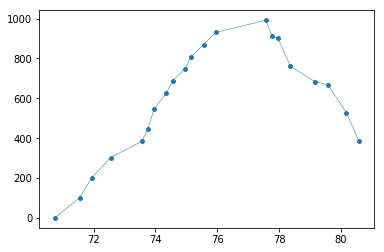

In [335]:
plt.scatter(bins[has_slope_info], curve[has_slope_info], s=15)
plt.plot(bins[has_slope_info], curve[has_slope_info], lw=.5)